In [ ]:
%pip install torch torchvision

In [19]:
import torch
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader


In [13]:
from src.helper_functions import plot_random_image_and_label, print_model_parameter_breakdown

In [14]:
from src.model import NeuralNetwork, train_model, evaluate_model

In [15]:
from src.data import WasteClassificationDataset

In [34]:
from src.plots import plot_loss_curves, plot_accuracy_curves, plot_confusion_matrix
from src.metrics import print_metrics_summary, print_classification_report

In [ ]:
from src.config import TRANSFORM_CONFIG, MODEL_CONFIG, MODEL_ARCHITECTURE_CONFIG

In [17]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


# Creating a Custom Dataset For Your Files:

A custom Dataset class must implement three functions: __init__, __len__, and __getitem__

In [7]:
train_transforms = transforms.Compose([
    transforms.Resize(TRANSFORM_CONFIG["image_size"]),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=TRANSFORM_CONFIG["normalize_mean"], 
        std=TRANSFORM_CONFIG["normalize_std"]
    )
])

test_transforms = transforms.Compose([
    transforms.Resize(TRANSFORM_CONFIG["image_size"]),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=TRANSFORM_CONFIG["normalize_mean"], 
        std=TRANSFORM_CONFIG["normalize_std"]
    )
])

In [20]:
train_dataset = WasteClassificationDataset("./data/train", transform=train_transforms)
test_dataset = WasteClassificationDataset("./data/test", transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=MODEL_CONFIG["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=MODEL_CONFIG["batch_size"], shuffle=False)



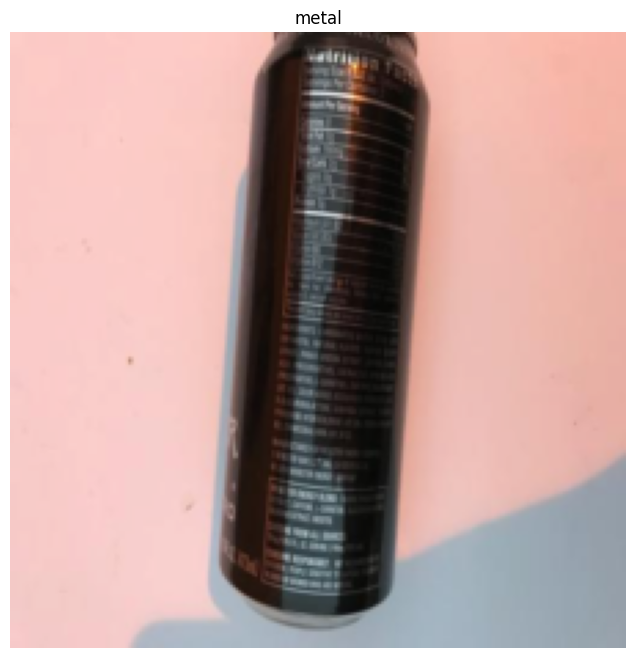

Index: 600
Label (integer): 1
Class name: metal
Image tensor shape: (224, 224, 3)


In [21]:
plot_random_image_and_label(
    train_dataset, 
    train_dataset.classes,
    mean=TRANSFORM_CONFIG["normalize_mean"],
    std=TRANSFORM_CONFIG["normalize_std"]
)

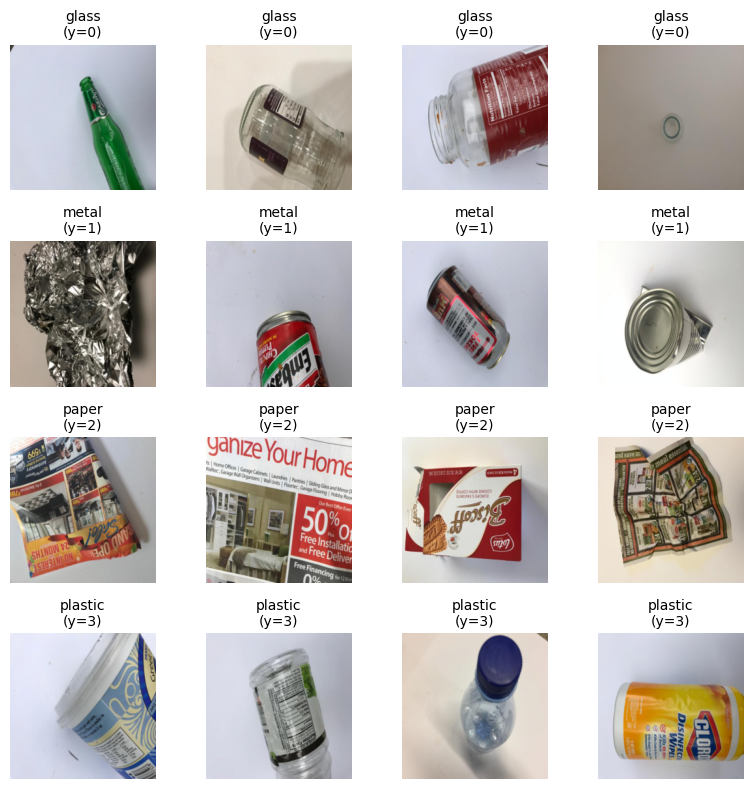

In [22]:
# Plot sample images from each class using the plot_stuff method
train_dataset.plot_stuff(num_samples_per_class=4, show_transformed=True)


# Introduction
- summarize your work, clearly stating the project's objectives. 

<div style = "color:blue">
    We are given a Waste Dataset, divided into training and test set with each having for class labels (glass, metal, paper, and plastic) and our goal is to develop a Deep Neural Network to classify images correctly into one of these types. 
    For this project, I will be using PyTorch for my Implementation
</div>

# Deep Learning Architecture:

Explain your Deep Learning Architecture: What kind of Deep Learning architecture did you use in your project, and why? Number of layers? Number of hidden units? etc.


<div style = "color:purple">
https://medium.com/@sahin.samia/mastering-the-basics-of-torch-nn-a-comprehensive-guide-to-pytorchs-neural-network-module-9f2d704e8c7f <br>

torch.nn = It provides a rich collection of tools to define, manage, and manipulate deep learning models efficiently. With torch.nn, you can construct everything from simple feedforward networks to highly complex architectures like convolutional and recurrent neural networks. <br>

Every model in PyTorch is essentially a subclass of nn.Module, making it the essential blueprint for neural network design. It provides:

Initialization (__init__): Define the layers and components of your network. <br>
Forward Pass (forward): Specify how data flows through the layers of your network. <br>
Parameter Management: Automatically tracks and optimizes model parameters.<br>

<br>
- Common Layers in nn <br>

1. nn.Linear: Fully Connected Layer <br>
Purpose: Applies a linear transformation: y = xW^T + b <br>
Common Use: Used in feedforward networks for dense connections between layers.<br>

2. nn.ReLU: Activation Function <br>
Purpose: Applies the ReLU function: ReLU(x)=max⁡(0,x) <br>
Common Use: Adds non-linearity after linear <br>

3. nn.Dropout: Dropout Regularization <br>
Purpose: Randomly sets a fraction of input neurons to zero during training to prevent overfitting. <br>
Common Use: Used after fully connected layers or in deeper architectures. <br>
</div>

In [23]:
image, label = train_dataset[0]
image.shape # need to flatten the image



torch.Size([3, 224, 224])

In [ ]:
# instance of the model
model_instance_one_no_dropout = NeuralNetwork(
    input_size=MODEL_ARCHITECTURE_CONFIG["input_size"],           
    hidden_sizes=MODEL_ARCHITECTURE_CONFIG["hidden_sizes"], 
    num_classes=MODEL_ARCHITECTURE_CONFIG["num_classes"],
    dropout_rates=MODEL_ARCHITECTURE_CONFIG["dropout_rates"]
)

In [25]:
print_model_parameter_breakdown(model_instance_one_no_dropout)


                     DETAILED PARAMETER CALCULATION BREAKDOWN: Model                      

──────────────────────────────────────────────────────────────────────────────────────────
LAYER 1: Linear(150,528 → 512)
──────────────────────────────────────────────────────────────────────────────────────────
  Input size:  150,528
  Output size: 512

  WEIGHTS:
    • Shape: (512, 150,528)
    • Calculation: 150,528 × 512 = 77,070,336
    • Actual count: 77,070,336 ✓

  BIAS:
    • Shape: (512,)
    • Calculation: 512 × 1 = 512
    • Actual count: 512 ✓

  LAYER TOTAL: 77,070,336 + 512 = 77,070,848
  Cumulative: 77,070,848

──────────────────────────────────────────────────────────────────────────────────────────
LAYER 2: Linear(512 → 256)
──────────────────────────────────────────────────────────────────────────────────────────
  Input size:  512
  Output size: 256

  WEIGHTS:
    • Shape: (256, 512)
    • Calculation: 512 × 256 = 131,072
    • Actual count: 131,072 ✓

  BIAS:
    • Shape:

In [26]:
model_instance_one_no_dropout = model_instance_one_no_dropout.to(device)

# Loss function:

Which loss function did you select to use and why?


Plot the change in your loss function (both training loss and test loss) vs epoch. Your code shall generate the “Change of Training and Test losses vs Epoch’ graph

Discuss these loss curves

<div style = "color:purple">
    Used to quantify the difference between predicted and actual. <br><br>
    Common Activation Functions <br>
    1. nn.MSELoss: Mean Squared Error Loss<br>
    Purpose: Measures the average squared difference between the predicted values and the actual target values. <br>
    Common Use: Used in regression tasks where the goal is to predict continuous values. <br><br>
    2. nn.CrossEntropyLoss: Cross-Entropy Loss <br>
    Purpose: Combines nn.LogSoftmax and nn.NLLLoss to calculate the cross-entropy between predicted probabilities and true class labels. <br>
    Common Use: Used in multi-class classification tasks. <br><br>
    3. nn.BCELoss: Binary Cross-Entropy for binary classification problems. <br><br>
    4. nn.BCEWithLogitsLoss: Combines a Sigmoid activation with Binary Cross-Entropy, more numerically stable than using nn.BCELoss with a separate Sigmoid.<br><br>
    5. nn.HingeEmbeddingLoss: Useful for tasks like similarity learning or when using SVM-like objectives.<br><br>
    6. nn.SmoothL1Loss: Combines MSE and L1 losses to handle outliers more gracefully.<br><br>
</div>


In [27]:
criterion = nn.CrossEntropyLoss()

<div style = "color:darkblue">
    Optimizers and torch.optim Integration <br><br>
    Models built with torch.nn automatically track their trainable parameters (e.g., weights and biases). <br>
    These parameters are passed to an optimizer from torch.optim to compute and apply parameter updates. <br><br>
    torch.nn defines the structure and forward computation of the model. <br>
    torch.optim takes care of adjusting the model's parameters during training based on the gradients computed by backpropagation. <br><br>
    torch.nn computes the forward pass and loss.<br>
    Gradients are computed via loss.backward().<br>
    torch.optim updates parameters using optimizer.step().<br><br>
    1. Stochastic Gradient Descent (SGD)<br>
        Description: Updates parameters by moving them in the direction of the negative gradient of the loss function.<br>
        Configuration:<br>
        lr (learning rate): Controls the step size for updates.<br>
        momentum: Adds inertia to the updates, helping to overcome small local minima.<br><br>
    2.  Adam Optimizer <br>
        Description: Combines the benefits of SGD with momentum and adaptive learning rates. <br>
        Configuration: <br>
        lr: Learning rate.<br>
        betas: Coefficients for computing moving averages of gradient and its square (default: (0.9, 0.999)).<br>
        eps: Small value to prevent division by zero.<br><br>
    3. RMSprop<br>
        Description: Similar to Adam but uses only squared gradients to adjust learning rates.<br>
        Common Use: Suitable for recurrent neural networks.<br><br>
    4. Adagrad: Adjusts learning rates for individual parameters based on their updates.<br><br>
    5. AdamW: A variant of Adam with decoupled weight decay for better generalization.<br><br>
</div>

In [28]:
optimizer = torch.optim.Adam(
    model_instance_one_no_dropout.parameters(),              
    lr=MODEL_CONFIG["learning_rate"]       
)

In [31]:
history_model_one_no_dropout = train_model(
    model=model_instance_one_no_dropout,
    train_loader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=MODEL_CONFIG["epochs"],
    test_loader=test_loader,  
    verbose=True
)

Epoch [1/10]
  Train - Loss: 0.6919, Acc: 0.7669, F1: 0.7649, Precision: 0.7637, Recall: 0.7669
  Test  - Loss: 1.8392, Acc: 0.6000, F1: 0.5791, Precision: 0.6432, Recall: 0.6000
--------------------------------------------------
Epoch [2/10]
  Train - Loss: 0.7047, Acc: 0.7351, F1: 0.7346, Precision: 0.7347, Recall: 0.7351
  Test  - Loss: 1.8446, Acc: 0.6200, F1: 0.6177, Precision: 0.6172, Recall: 0.6200
--------------------------------------------------
Epoch [3/10]
  Train - Loss: 0.5702, Acc: 0.7883, F1: 0.7882, Precision: 0.7890, Recall: 0.7883
  Test  - Loss: 1.3355, Acc: 0.5700, F1: 0.5743, Precision: 0.5833, Recall: 0.5700
--------------------------------------------------
Epoch [4/10]
  Train - Loss: 0.5098, Acc: 0.8039, F1: 0.8019, Precision: 0.8014, Recall: 0.8039
  Test  - Loss: 2.3057, Acc: 0.5300, F1: 0.5095, Precision: 0.5739, Recall: 0.5300
--------------------------------------------------
Epoch [5/10]
  Train - Loss: 0.6780, Acc: 0.7831, F1: 0.7823, Precision: 0.7820,

In [32]:
test_model_instance_one_no_dropout = evaluate_model(
    model=model_instance_one_no_dropout,
    data_loader=test_loader,
    criterion=criterion,
    device=device
)

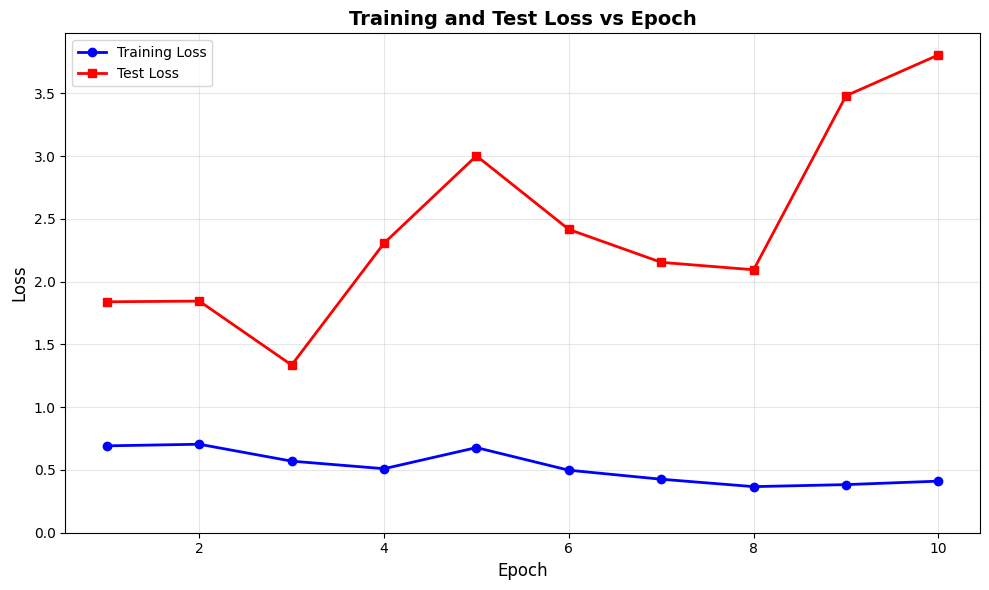

In [35]:
plot_loss_curves(history_model_one_no_dropout)

# Hyperparameters

The number of layers


Number of nodes at each layer


Learning rate


“Mini batch” size
- What is the mini-batch size you used in your code?


- Why did you select this value?



Activation functions
- What is the activation function(s) used in your code?



- Why did you select them to use?



Optimization function
- Which optimization function did you use? Why?



- What are the optimization parameters used?


Regularization function 
- Did you use any regularization function?




- Why used/ not used?




- If used, what are the regularization parameters?




Epochs
- What is the number of epochs used?




- Why did you select this value?





# Explanation of the developed code

Explain the essential functions/classes you developed in your code.

Explain how to run your code if you are using the “command prompt” or any environment other than VS Code and Jupyter. 

<div style = "color:blue">
- WasteClassificationDataset Class
This class was was created by inheriting the Dataset Class provided by PyTorch. Three required methods were created which include _init__, __len__ and __getitem__ which are required by PyTorch Dataset interface.

The images were organized by class folders(paper, metal, glass, plastic), which made it easier to create class labels for the dataset.

This could've been done using base Python as well, but PyTorch provides additional helpful tooks like Automatic Differentiation for back propogation, optimizers etc which is why we need PyTorch to convert the dataset into tensors.

<div>


# Hyperparameter Optimization 

Optimize your “learning rate” and “number of layers
What is the effect of “optimization” on “learning rate” and “number of layers”?  (indicate starting values and the optimized values)





How did you optimize your hyperparameters?






What are the optimization results (show the numerical values and state how you improved them)




# Discuss the Performance of Your Model:

- Confusion matrix 

What is the metric selected to evaluate your model?


What is the best metric value obtained? 


What kind of error(s) do you have in your model? Discuss your errors, state what they mean. 


Due to the errors stated above, what shall be done to improve your model’s performance?


Which techniques have you applied to improve your model’s performance? 


Do you have overfitting or underfitting/overfitting in your model? Which processes did you apply to prevent underfitting/overfitting? 



# Error analysis and misclassified examples

Please discuss the error analysis you performed in your project.


# Deep Learning Strategies

What are the Deep Learning Strategies you performed in this project? 




If they exist, why did you select these strategies to apply? 


# Discussion and Conclusion

Discuss your results and draw conclusions from your work. State what you learned in this project. 
